In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sourcesep.utils.config import load_config

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=1.3, rc=custom_params)
%config InlineBackend.figure_format='retina'

paths = load_config(dataset_key="all")

Paths are for dataset tagged: all


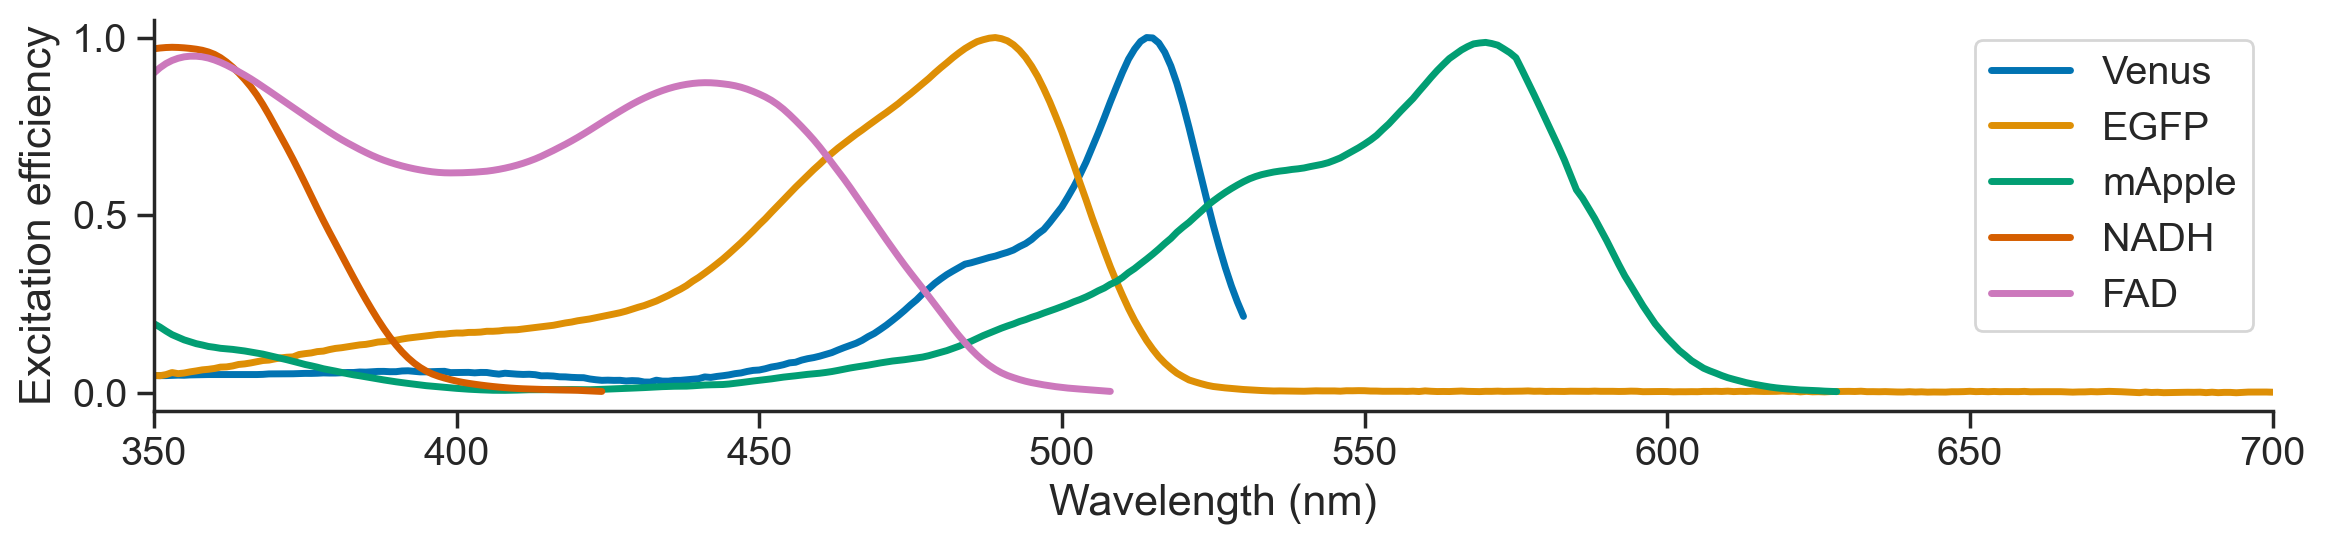

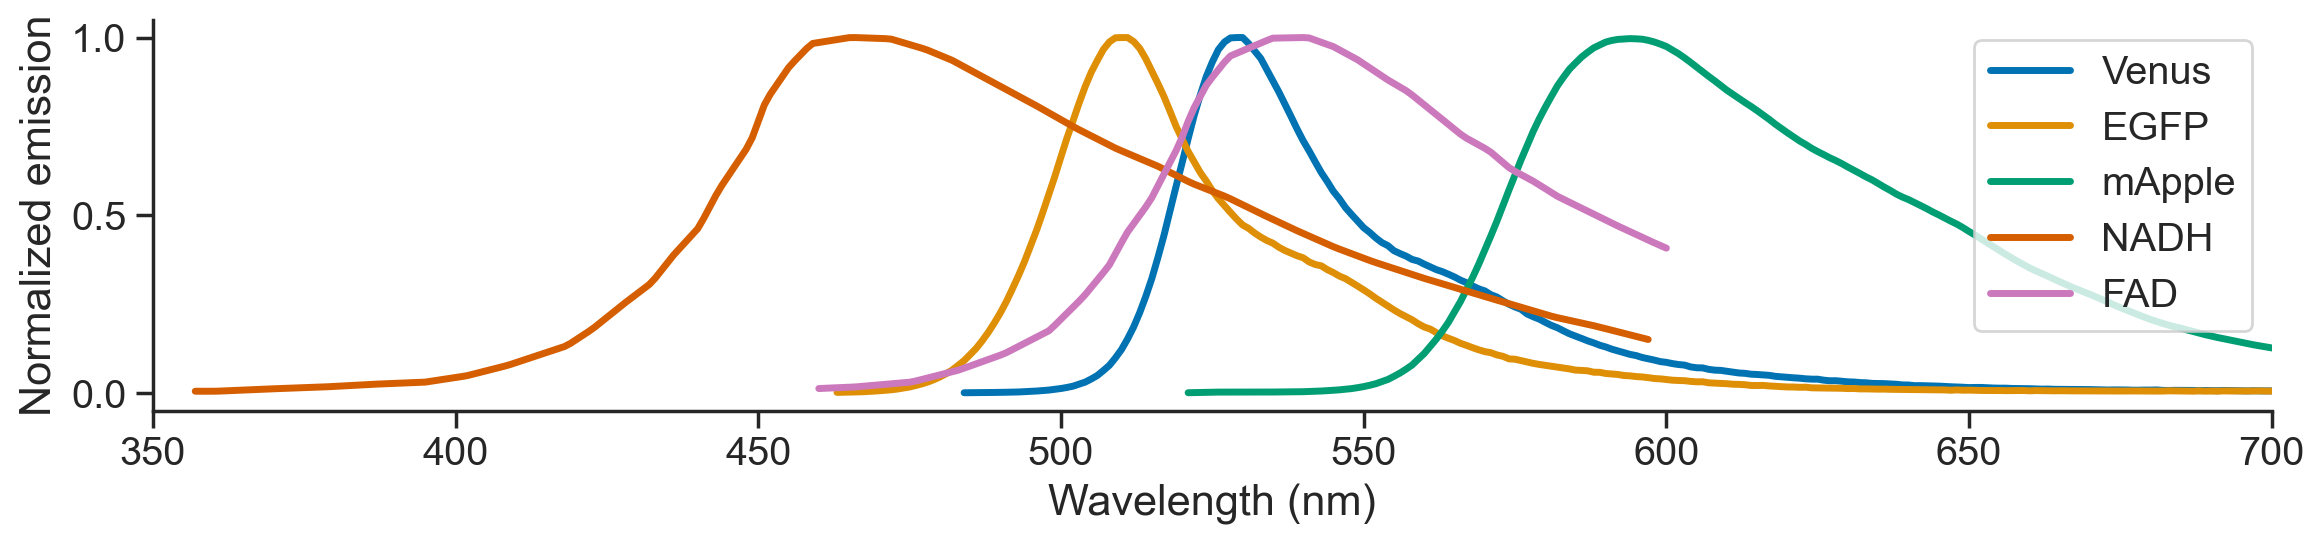

In [2]:
cc = sns.color_palette("colorblind", n_colors=5)

f1, ax1 = plt.subplots(1, 1, figsize=(12, 3))
for i, af_src in enumerate(["Venus", "EGFP", "mApple", "NADH", "FAD"]):
    df = pd.read_csv(paths["spectra"] / f"{af_src}.csv")
    df_ = df[["wavelength", f"{af_src} ex"]].copy()
    df_.dropna(inplace=True)
    if af_src in ["NADH", "FAD"]:
        df_[f"{af_src} ex"] = df_[f"{af_src} ex"] / 100
    if af_src in ["mApple", "NADH", "FAD"]:
        df_[f"{af_src} ex"] = np.convolve(df_[f"{af_src} ex"].values, np.ones(10) / 10, mode="same")
    ax1.plot(df_["wavelength"], df_[f"{af_src} ex"], c=cc[i], label=f"{af_src}", linewidth=2.5)
    ax1.set(xlabel="Wavelength (nm)", ylabel="Excitation efficiency", xlim=(350, 700))
    ax1.legend(loc="upper right")

plt.tight_layout()
plt.savefig("excitation_spectra.png", dpi=300)
plt.show()

f2, ax2 = plt.subplots(1, 1, figsize=(12, 3))
for i, af_src in enumerate(["Venus", "EGFP", "mApple", "NADH", "FAD"]):
    df = pd.read_csv(paths["spectra"] / f"{af_src}.csv")
    df_ = df[["wavelength", f"{af_src} em"]].copy()
    df_.dropna(inplace=True)
    if af_src in ["NADH", "FAD"]:
        df_[f"{af_src} em"] = df_[f"{af_src} em"] / df_[f"{af_src} em"].max()
    if af_src in ["mApple"]:
        df_[f"{af_src} em"] = np.convolve(df_[f"{af_src} em"].values, np.ones(10) / 10, mode="same")
    ax2.plot(df_["wavelength"], df_[f"{af_src} em"], c=cc[i], label=f"{af_src}", linewidth=2.5)
    ax2.set(xlabel="Wavelength (nm)", ylabel="Normalized emission", xlim=(350, 700))
    ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [3]:
import h5py
from tqdm import tqdm
from aind_ophys_utils.dff import dff

paths = load_config(dataset_key="all")
f = h5py.File(paths["root"] / "HSFP_670128_2023-04-27_data_preprocessed.hdf5", "r")
print(f.keys())

xj = {}
for j in np.argsort(f["Lasers"][:]):
    xj[j] = f[f"Channel{j+1}"][:].astype(float)

t = f["Time"][:]
l = f["Wavelength"][:]
lasers = f["Lasers"][:][np.argsort(f["Lasers"][:])]

print(f"\nsampling frequency: {1/(np.max(t) / t.size):0.2f} Hz")
print(f"length of recording: {np.max(t)-np.min(t):0.2f} seconds")
print(f"\neach channel has dimensions of {xj[0].shape}")
print(f"min. wavelength: {np.min(l):0.2f} nm")
print(f"max. wavelength: {np.max(l):0.2f} nm")

# laser intensity (close to emission peak of laser) is orders of magnitude
# larger than the signal intensity from indicators (close to emission peak of fluorophore).
# here we use aind utils to obtain the df/f and f0 signals independently for each pixel in each channel.

rel_xj = {}
f0_xj = {}
mean_per_px = {}

for j in range(len(xj)):
    dff_signal_list = []
    f0_signal_list = []
    for px in tqdm(range(xj[j].shape[1])):
        dff_signal, f0_signal, signal_sd = dff(
            xj[j][:, px], fs=23.99, long_window=20.0, short_window=2.0, inactive_percentile=5
        )
        # check if nan in dff_signal, set to a very small value if so
        if np.isnan(dff_signal).any():
            dff_signal = np.zeros(dff_signal.shape) + 1e-6 * np.random.randn(dff_signal.shape[0])
        dff_signal = dff_signal + np.abs(np.min(dff_signal[dff_signal < 0]))  # if negative, push to 0
        dff_signal_list.append(dff_signal)
        f0_signal_list.append(f0_signal)

    rel_xj[j] = np.vstack(dff_signal_list).T
    f0_xj[j] = np.vstack(f0_signal_list).T

Paths are for dataset tagged: all
<KeysViewHDF5 ['Channel1', 'Channel2', 'Channel3', 'Channel4', 'Channel5', 'Lasers', 'Time', 'Wavelength']>

sampling frequency: 23.99 Hz
length of recording: 448.23 seconds

each channel has dimensions of (10752, 300)
min. wavelength: 400.00 nm
max. wavelength: 699.00 nm


100%|██████████| 300/300 [00:05<00:00, 53.06it/s]


In [4]:
def coef_fn(x, y):
    c = np.dot(x - np.mean(x), y - np.mean(y)) / np.size(x)
    c = c / (np.std(x) * np.std(y) + 1e-10)
    return c


def get_coef_mats(J, L, dat):
    coef_list = []
    for j in range(J):
        coef = np.empty((L, L))
        coef[:] = np.nan
        for l1 in range(L):
            for l2 in range(l1, L):
                coef[l1, l2] = coef_fn(dat[j][:, l1], dat[j][:, l2])
        coef_list.append(coef)
    return coef_list

In [5]:
cc_list = get_coef_mats(J=len(rel_xj), L=rel_xj[0].shape[1], dat=rel_xj)

In [6]:
laser_list = [514, 560, 473, 405, 445]  # order of lasers in the data
# coef_list = [cc_list[3], cc_list[4],cc_list[2],cc_list[0], cc_list[1]]
# laser_list = [laser_list[3], laser_list[4], laser_list[2], laser_list[0], laser_list[1]]

coef_list = [cc_list[4], cc_list[2], cc_list[0]]
laser_list = [laser_list[4], laser_list[2], laser_list[0]]

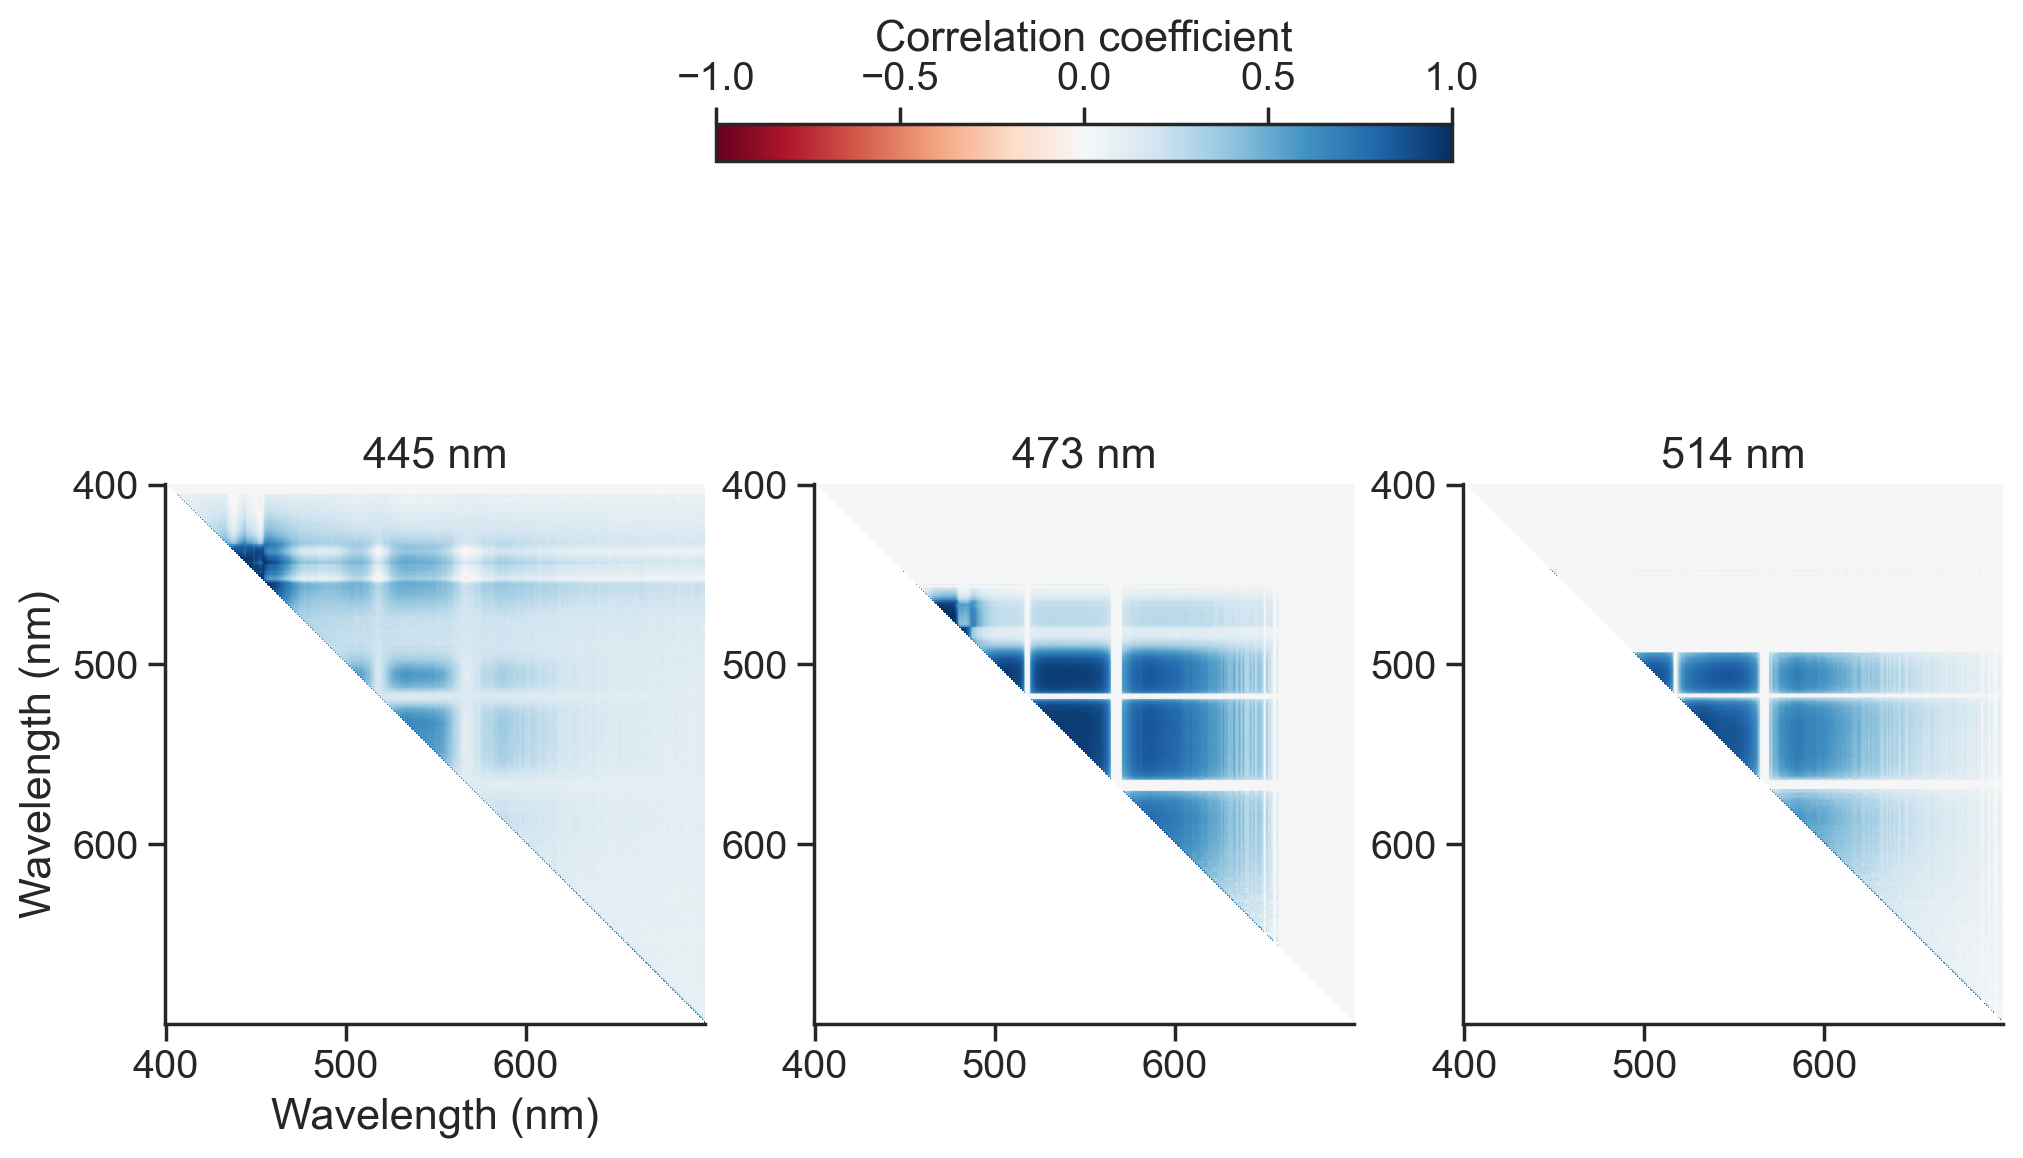

In [7]:
cmap = plt.get_cmap("RdBu").copy()
cmap.set_bad(color="w", alpha=1.0)
J = len(coef_list)
f, ax = plt.subplots(1, J, figsize=(10, 10 * J), constrained_layout=True)
for j in range(J):
    i = ax[j].imshow(coef_list[j], vmin=-1, vmax=1, aspect=1, cmap=cmap)
    ax[j].axis("on")
    xticks = np.arange(0, coef_list[j].shape[0], 100)
    yticks = np.arange(0, coef_list[j].shape[0], 100)
    if j == 0:
        ax[j].set(
            xticks=xticks,
            xticklabels=l[xticks],
            yticks=yticks,
            yticklabels=l[yticks],
            xlabel="Wavelength (nm)",
            ylabel="Wavelength (nm)",
        )
    else:
        ax[j].set(xticks=xticks, xticklabels=l[xticks], yticks=yticks, yticklabels=l[yticks])

    ax[j].set(title=f"{laser_list[j]} nm")

    ax[j].grid(False)
f.colorbar(i, ax=ax[:], location="top", shrink=0.4, label="Correlation coefficient")


plt.show()

In [8]:
from sourcesep.sim import SimData

paths = load_config(dataset_key="all")
sim = SimData(T=200, cfg_path=paths["root"] / "sim_autofl.toml")
_ = sim.get_S()
_ = sim.get_W()
_ = sim.get_E()

sim.W_df.iloc[-2, :] = sim.W_df.iloc[-2, :] / 100
sim.W_df.iloc[-1, :] = sim.W_df.iloc[-1, :] / 100

print(sim.W_df)

Paths are for dataset tagged: all
Paths are for dataset tagged: all
            405      445      473     514     561
Venus   0.05720  0.05050  0.21740  1.0000  0.0000
EGFP    0.17320  0.39150  0.81430  0.1469  0.0043
mApple  0.00690  0.02940  0.09200  0.3863  0.8972
NADH    0.01707  0.00000  0.00000  0.0000  0.0000
FAD     0.62471  0.86766  0.37306  0.0000  0.0000


NMF objective with sparsity from Neher et al. 2009:

$$
L = \sum_{\lambda,t}(y_{\lambda t} - \sum_s a_{\lambda s} x_{s t})^2 
- \alpha \sum_t\frac{\sum_s{\lvert x_{st} \rvert}}{{(\sum_s{|x_{st}^2|)}^\frac{1}{2}}} + \beta_{pq}\sum_\lambda{a_{\lambda p}a_{\lambda q}}
$$

In [1]:
# Load pickle file
import matplotlib.pyplot as plt
import seaborn as sns
from sourcesep.utils.config import load_config

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=1.3, rc=custom_params)
%config InlineBackend.figure_format='retina'

paths = load_config(dataset_key="all")


import pickle

with open(paths["root"] / "results/00_nmf_single_indicator_fit.pkl", "rb") as f:
    res = pickle.load(f)

with open(paths["root"] / "sims/nmf_single_indicator_test_data_autofl.pkl", "rb") as f:
    dat = pickle.load(f)

res = res["res_fine_tune_5"]
print(res.keys())
print(dat.keys())

Paths are for dataset tagged: all
dict_keys(['A', 'X', 'err'])
dict_keys(['Y', 'A_corr', 'X_roi', 'A_keep', 'X_keep', 'A_init_0', 'X_init_0', 'l_channels', 'n_px_in_ch', 'l', 't'])


In [2]:
from sourcesep.models.nmf_variants import set_norm

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=1.6, rc=custom_params)
%config InlineBackend.figure_format='retina'

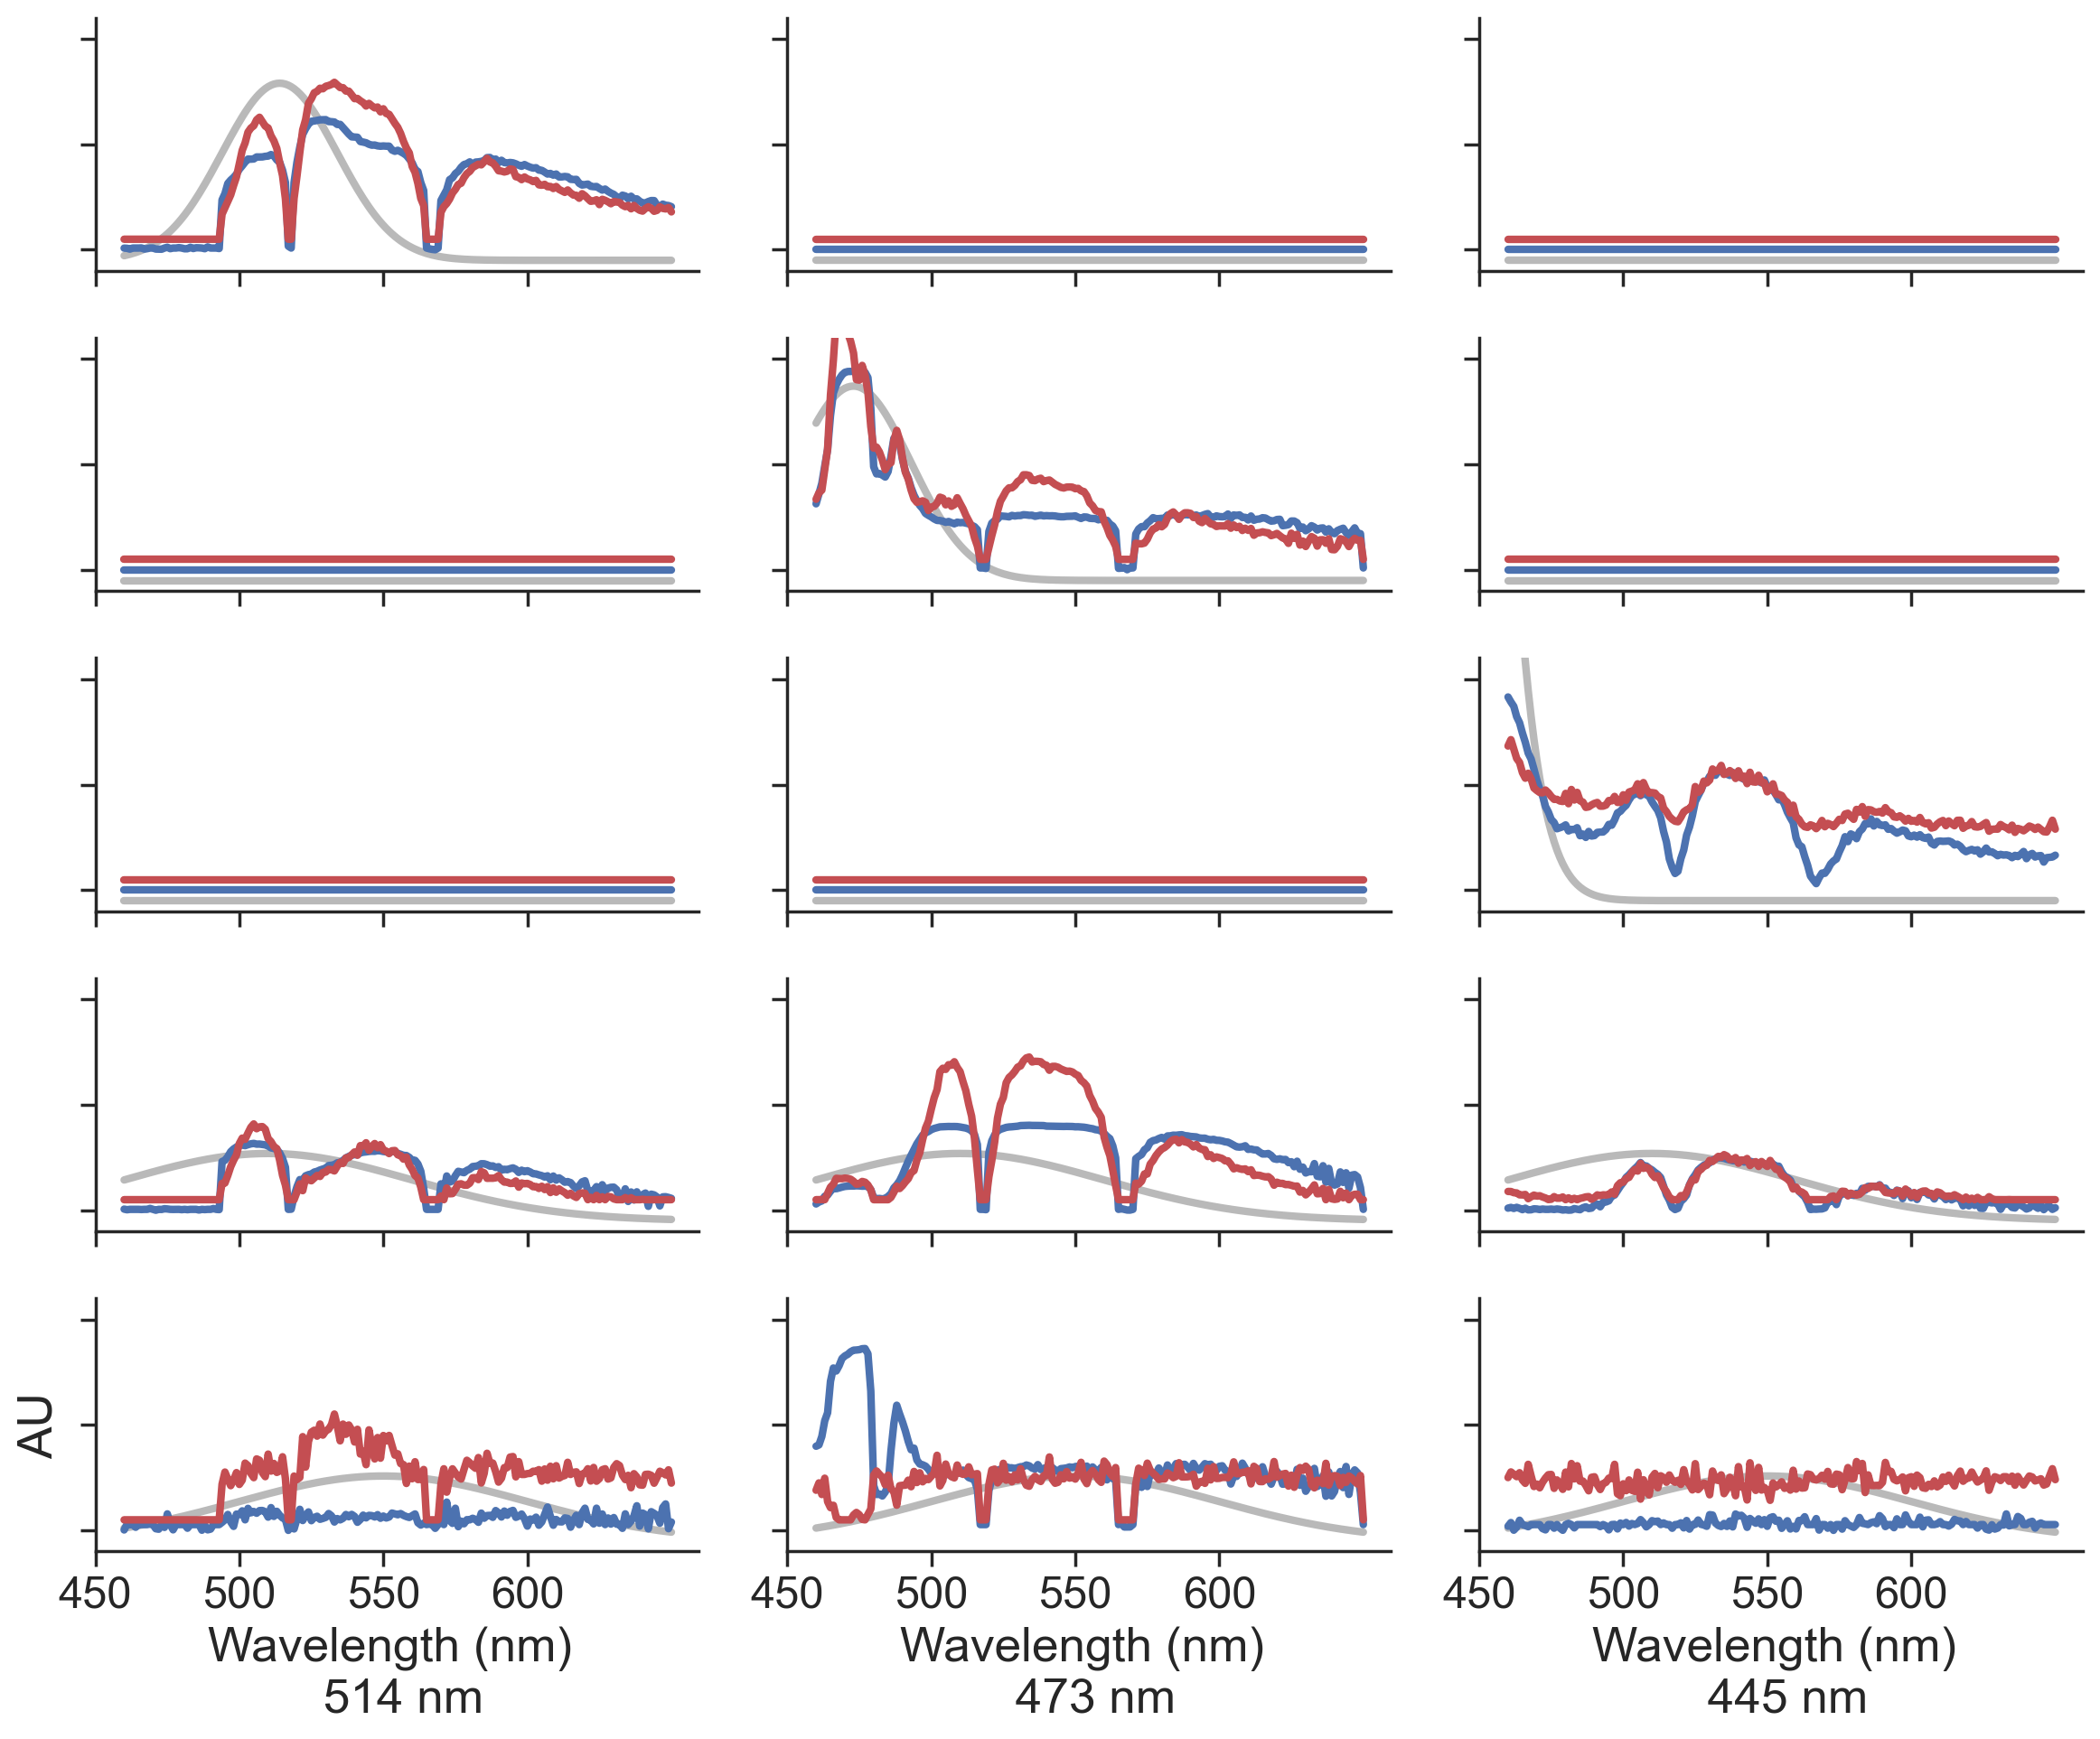

In [3]:
A_init = set_norm(dat["A_init_0"], axis=0, c=10.0)[0]
A_aprx = set_norm(dat["A_corr"], axis=0, c=10.0)[0]
A_fit = set_norm(res["A"], axis=0, c=10.0)[0]

dat["l_channels"]
laser = ["514 nm", "473 nm", "445 nm"]

f, ax = plt.subplots(5, len(dat["l_channels"].keys()), figsize=(12, 10))
for s in range(5):
    for k, key in enumerate(dat["l_channels"].keys()):
        l_channel = dat["l_channels"][key]
        ax[s, k].plot(
            l_channel, A_init[k * 191 : (k + 1) * 191, s].T - 0.1, linewidth=3, c="k", alpha=0.3, label="Initialized"
        )
        ax[s, k].plot(l_channel, A_aprx[k * 191 : (k + 1) * 191, s].T, c="b", linewidth=3, label="Estimate")
        ax[s, k].plot(l_channel, A_fit[k * 191 : (k + 1) * 191, s].T + 0.1, c="r", linewidth=3, label="Fit")
        ax[s, k].set(ylim=(-0.2, 2.2), xticks=[450, 500, 550, 600], yticks=[0, 1, 2], yticklabels=[])
        if s == 4 and k == 0:
            ax[s, k].set(xlabel="Wavelength (nm)", ylabel="AU")
        if s == 4:
            ax[s, k].set(xlabel=f"Wavelength (nm) \n {laser[k]}")
        if s != 4:
            ax[s, k].set(xticklabels=[], ylabel="")
        if k == 0 and s == 4:
            ax[s, k].set(ylabel="AU")

plt.tight_layout()
plt.show()